In [1]:
%run ../tools/get_SERCA_equilibrium.ipynb

In [2]:
import numpy as np
from scipy.integrate import *
import matplotlib.pyplot as plt
from math import *
from scipy.optimize import *

In [3]:
cai = 100.0e-9
cae = 250e-6

N_avo=6.0221409e23

# Volume Normalisations
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
ntot = 1
ctot = ntot/vol_tot
fvol_cyt = vol_cyt/vol_tot
fvol_er = vol_er/vol_tot

In [4]:
# Reaction Rates
k_orig={
    'kx1_x1a' : 2*1.0e8,
    'kx1a_x2' : 1.0e8,
    'kx1a_x1' : 83.666,
    'kx2_x1a' : 2*83.666,
    'kx2_y2'  : 0.6,
    'ky2_x2'  : 4.118, #corrected
    'ky2_y1a' : 2*30.015,
    'ky1a_y1' : 30.015,
    'ky1a_y2' : 1.0e5,
    'ky1_y1a' : 2*1.0e5,
    'ky1_x1'  : 0.4,
    'kx1_y1'  : 1.20e-3,
    'kleak'     : 0,

    'cbHon'   : 0.55e7,
    'cbHoff'  : 2.6,
    'cbMon'   : 4.35e7,
    'cbMoff'  : 35.8,
     
    'kPMCA01' : 1.5e8,
    'kPMCA10' : 20,
    'kPMCA12' : 100,
    'kPMCA20' : 1e5,
    'kPMCA0leak': 12.5

}

In [5]:
# ODE model
class new_model:
    # Volume Normalisations
    vol_er = (3.9*0.1*0.1)
    vol_cyt = (4.0*0.5*0.5-vol_er)
    vol_tot = vol_cyt + vol_er
    ntot = 1
    ctot = ntot/vol_tot
    fvol_cyt = vol_cyt/vol_tot
    fvol_er = vol_er/vol_tot
    N=0.00026033316269814734
    er_clamp=0
    flux=[]
    def __init__(self,parameters):
        self.__dict__.update(parameters)
    def ode(self,v,t):
        Ca, PMCA0, PMCA1, PMCA2,\
        cbH0M0, cbH0M1, cbH0M2, cbH1M0, cbH1M1, cbH1M2, cbH2M0, cbH2M1, cbH2M2,\
        fx1, fx1a, fx2, fy2, fy1a, fy1, cae = v 

        dx1 = fx1*(-self.kx1_x1a*cai-self.kx1_y1)+fx1a*self.kx1a_x1+fy1*self.ky1_x1
        dx1a = fx1a*(-self.kx1a_x2*cai-self.kx1a_x1)+fx1*cai*self.kx1_x1a+fx2*self.kx2_x1a
        dx2 = fx2*(-self.kx2_y2-self.kx2_x1a)+fx1a*cai*self.kx1a_x2+fy2*self.ky2_x2

        dy1 = fy1*(-self.ky1_y1a*cae-self.ky1_x1)+fy1a*self.ky1a_y1+fx1*self.kx1_y1
        dy1a = fy1a*(-self.ky1a_y2*cae-self.ky1a_y1)+fy1*cae*self.ky1_y1a+fy2*self.ky2_y1a
        dy2 = fy2*(-self.ky2_x2-self.ky2_y1a)+fy1a*cae*self.ky1a_y2+fx2*self.kx2_y2

        dcae = self.N*(-cae*(fy1a*self.ky1a_y2 + fy1*self.ky1_y1a) + (fy1a*self.ky1a_y1 + fy2*self.ky2_y1a))
        dCa = (Ca*(-fx1*self.kx1_x1a-fx1a*self.kx1a_x2)+fx2*self.kx2_x1a+fx1a*self.kx1a_x1)

        #er leaks
        dcae += self.kleak*(Ca - cae)
        dCa += -self.vol_er/self.vol_cyt*self.kleak*(Ca - cae)

        if self.er_clamp!=0:
            self.flux.append(dcae)
            dcae=0
            
        ### PMCA
        dCa   +=  (self.kPMCA0leak - self.kPMCA01*Ca)*PMCA0 + self.kPMCA10*PMCA1
        dPMCA0 = + self.kPMCA20*PMCA2 + self.kPMCA10*PMCA1 - self.kPMCA01*Ca*PMCA0
        dPMCA1 = - (self.kPMCA12 + self.kPMCA10)*PMCA1 + self.kPMCA01*Ca*PMCA0
        dPMCA2 = - self.kPMCA20*PMCA2 + self.kPMCA12*PMCA1

        ### Calcium Buffers
        dCa   +=     self.cbMoff*(cbH2M1 + cbH1M1 + cbH0M1 + 2*(cbH2M2 + cbH1M2 + cbH0M2)) \
                + self.cbHoff*(cbH2M1 + cbH1M1 + cbH0M1 + 2*(cbH2M2 + cbH2M1 + cbH2M0)) \
             - (+ self.cbMon*(cbH2M1 + cbH1M1 + cbH0M1  + 2*(cbH2M0 + cbH1M0 + cbH0M0)) \
                + self.cbHon*(cbH2M1 + cbH1M1 + cbH0M1  + 2*(cbH0M2 + cbH0M1 + cbH0M0)) )*Ca

        dcbH0M0 = - 2*(self.cbMon+self.cbHon)*cbH0M0*Ca + self.cbMoff*cbH0M1 + self.cbHoff*cbH1M0

        dcbH0M1 = + (2*self.cbMon*cbH0M0 - (self.cbMon + 2*self.cbHon)*cbH0M1)*Ca \
                  + self.cbMoff*(2*cbH0M2 - cbH0M1) + self.cbHoff*cbH1M1

        dcbH0M2 = + self.cbMon*cbH0M1*Ca - 2*(self.cbMoff + self.cbHon*Ca)*cbH0M2 + self.cbHoff*cbH1M2

        dcbH1M0 = + (2*self.cbHon*cbH0M0 - (self.cbHon + 2*self.cbMon)*cbH1M0)*Ca\
                  + self.cbMoff*cbH1M1   + self.cbHoff*(2*cbH2M0 - cbH1M0)

        dcbH1M1 = - ((self.cbMon + self.cbHon)*Ca + (self.cbHoff + self.cbMoff))*cbH1M1\
                  + 2*((self.cbMoff*cbH1M2 + self.cbHoff*cbH2M1) + (self.cbMon*cbH1M0 + self.cbHon*cbH0M1)*Ca)

        dcbH1M2 = + (self.cbMon*cbH1M1 + 2*self.cbHon*cbH0M2 - self.cbHon*cbH1M2)*Ca\
                  - (2*self.cbMoff + self.cbHoff)*cbH1M2 + 2*self.cbHoff*cbH2M2

        dcbH2M0 = + self.cbMoff*cbH2M1 + self.cbHon*cbH1M0*Ca - 2*(self.cbHoff + self.cbMon*Ca)*cbH2M0

        dcbH2M1 = + (self.cbHon*cbH1M1 - self.cbMon*cbH2M1 + 2*self.cbMon*cbH2M0)*Ca\
                  + 2*(self.cbMoff*cbH2M2 - self.cbHoff*cbH2M1) - self.cbMoff*cbH2M1

        dcbH2M2 = + (self.cbMon*cbH2M1 + self.cbHon*cbH1M2)*Ca - 2*(self.cbHoff + self.cbMoff)*cbH2M2

        dX = [dCa, dPMCA0, dPMCA1, dPMCA2,\
              dcbH0M0, dcbH0M1, dcbH0M2, dcbH1M0, dcbH1M1, dcbH1M2, dcbH2M0, dcbH2M1, dcbH2M2,\
              dx1, dx1a, dx2, dy2, dy1a, dy1, dcae]

        return dX

# This is to see refilling:

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


[0.19379038 0.37901173 0.18531342 0.01327303 0.08670581 0.14190562] 
Ca ER = 749.9999999365107 uM


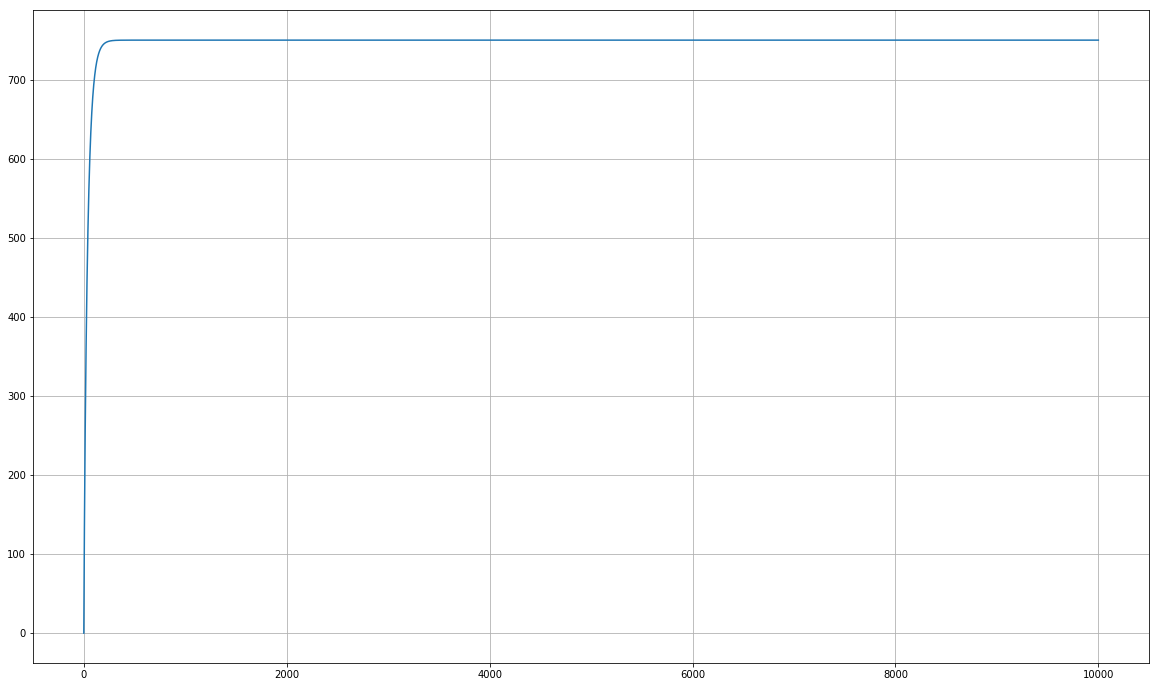

In [155]:
#constructing v0 initial vector
Ca=100e-9
cae=0#250.24e-6
pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
npmca = 180
p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM
v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]

#v0[-7:-1] =[ 0.6420802891222142, 0.30574391044577887, 0.035928792193863426, 0.005142394529773396, 0.008226136319601385, 0.002878477474144645] 

#Changing parameters
k=k_orig.copy()
#sf=5#1.2#2.56276565#3**(0.5)#15.077571633298069 
#sm=3.53087274 #for 500
#sm=1/np.polyval(fit1,sf)#0.06666667#4.475955225950996 #1.0910670852450743#2#1.57496328 #for 750


sf,sm=sols[5]#[8.19512923, 0.10158836]
k['kleak']=kleakrange[5]*0.2#*0.39623658#

for key in ['kx1_x1a','kx1a_x2','ky2_y1a','ky1a_y1']:
    k[key]=sf*k[key]
for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
    k[key]=sm*k[key]

#0.05#*0.2#*0.2#*0.087 #0.21405838101231592#0.09519188799639043
#print(k)

tstep = 1e-3
tf = 10000
t = np.linspace(0, tf, tf/tstep+1)
M=new_model(k)
# Solve ODE
sol = odeint(M.ode,v0,t)

plt.figure(figsize=(20,12))
plt.plot(t,sol[:,-1]*1e6)
plt.grid()

print(sol[-1,-7:-1],"\nCa ER =",sol[-1,-1]*1e6,"uM")

In [157]:
mols=['x1','x1a','x2','y2','y1a','y1']
for (m,a) in zip(mols,sol[-1,-7:-1]):
    print("serca_"+m+"_feq = "+str(a))

serca_x1_feq = 0.19379038120694989
serca_x1a_feq = 0.3790117340395536
serca_x2_feq = 0.18531341504308455
serca_y2_feq = 0.013273032416232263
serca_y1a_feq = 0.08670581220565597
serca_y1_feq = 0.14190562498324744


In [141]:
#first constraint

def opt_1(sf,sm,kleak):
    #constructing v0 initial vector
    Ca=100e-9
    cae=0#250.24e-6
    pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
    npmca = 180
    p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
    calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
    2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM
    v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]

    #v0[-7:-1] =[ 0.6420802891222142, 0.30574391044577887, 0.035928792193863426, 0.005142394529773396, 0.008226136319601385, 0.002878477474144645] 

    #Changing parameters
    k=k_orig.copy()
    #sf=3
    #sm=3.53087274
    for key in ['kx1_x1a','kx1a_x2','ky2_y1a','ky1a_y1']:
        k[key]=sf*k[key]
    for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
        k[key]=sm*k[key]

    k['kleak']=kleak#0.014#0.014 #0.21405838101231592#0.09519188799639043
    #print(k)

    tstep = 1e-2
    tf = 10000
    t = np.linspace(0, tf, tf/tstep+1)
    M=new_model(k)
    # Solve ODE
    sol = odeint(M.ode,v0,t)
    #print(sol[-1,-1])
    return sol[-1,-1]-250e-6

In [101]:
#second constraint
def opt_2(sf,sm,kleak):
    #constructing v0 initial vector
    Ca=100e-9
    cae=0#250.24e-6
    pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
    npmca = 180
    p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
    calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
    2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM
    v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]

    #v0[-7:-1] =[ 0.6420802891222142, 0.30574391044577887, 0.035928792193863426, 0.005142394529773396, 0.008226136319601385, 0.002878477474144645] 

    #Changing parameters
    k=k_orig.copy()
    #sf=3
    #sm=3.53087274

    #sm=1/np.polyval(fit1,sf)
    for key in ['kx1_x1a','kx1a_x2','ky2_y1a','ky1a_y1']:
        k[key]=sf*k[key]
    for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
        k[key]=sm*k[key]

    k['kleak']=kleak*0.2#0.014*0.2 #0.21405838101231592#0.09519188799639043
    #print(k)

    tstep = 1e-2
    tf = 10000
    t = np.linspace(0, tf, tf/tstep+1)
    M=new_model(k)
    # Solve ODE
    sol = odeint(M.ode,v0,t)
    #print(sol[-1,-1],"sf,sm=",sf,sm)
    return sol[-1,-1]-750e-6

In [102]:
def func(s,kleak):
    sf,sm=s
    res=[opt_1(sf,sm,kleak),opt_2(sf,sm,kleak)]
    print(sf,sm,res)
    return res

In [122]:
kleakrange=np.linspace(0.02,0.08,7)
sols=[]
for kleak in kleakrange:
    sols.append(fsolve(func,[8,0.04],args=(kleak,)))
    print('yay for', kleak)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


8.0 0.04 [-0.0001441860413730343, -0.00033570691642083816]
8.0 0.04 [-0.0001441860413730343, -0.00033570691642083816]
8.0 0.04 [-0.0001441860413730343, -0.00033570691642083816]
8.00000011920929 0.04 [-0.0001441860401885674, -0.00033570691084379146]
8.0 0.04000000059604645 [-0.00014418603987507663, -0.00033570691160613895]


/home/kabir/.local/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


-0.6029446214706056 0.1313851552498744 [-0.00025, -0.00075]
14.25773662924955 0.0022168140581946758 [-0.0002412976877498366, -0.0007071705447582954]
8.00000011920929 0.04 [-0.0001441860401885674, -0.00033570691084379146]
8.0 0.04000000059604645 [-0.00014418603987507663, -0.00033570691160613895]
-0.6029446214706056 0.1313851552498744 [-0.00025, -0.00075]
14.25773662924955 0.0022168140581946758 [-0.0002412976877498366, -0.0007071705447582954]
8.806132387072326 0.06547608818674415 [-7.049842307258315e-05, -0.0001304653357532458]
0.8632407858562416 0.09121888313168933 [-0.00023804454859484018, -0.0007057217800885215]
10.299139271335726 0.0899414678343973 [1.4818754524020187e-05, 9.822805074909667e-05]
7.596325341659698 0.11847726561562191 [1.724712819448093e-05, 9.807999926643245e-06]
8.277126532317698 0.10432047948683937 [7.56870261812108e-06, 1.7414560816677704e-05]
8.181354935372314 0.10158506283235244 [-3.291091843873103e-07, -1.1186127651535444e-06]
8.195208812736988 0.101575094300065

19.78288935343661 0.09401551486329039 [-8.786381249750215e-05, -4.9293939729142216e-05]
28.919610265023895 0.09548794774792171 [-6.550868730549934e-05, 7.489633536843644e-05]
28.919609834088128 0.09548794917080301 [-6.55086853116816e-05, 7.489634162486313e-05]
24.38782462502259 0.0938907247463788 [-7.672289293903653e-05, 1.4426280198640657e-05]
16.496307130908324 0.1057230102723256 [-8.078394345958706e-05, -4.7450736001959344e-05]
21.504559899686967 0.10296778445465814 [-6.780333850808638e-05, 3.281509356809875e-05]
14.077930723395092 0.11662488117424287 [-7.701779165166843e-05, -5.9406351488876436e-05]
18.537835931366597 0.11186744919499626 [-6.281033212617203e-05, 2.9399312616243596e-05]
12.266770230720446 0.12889398012069198 [-7.289430078777373e-05, -7.106869187225998e-05]
16.42108854299718 0.1222321083178653 [-5.599000167188305e-05, 3.161402221068502e-05]
11.336978765109857 0.141672705935663 [-6.497368792605289e-05, -6.455314075723688e-05]
14.741993846714301 0.1331076275265304 [-4.

8.0 0.04 [-0.00022264450950816198, -0.0006194432057874305]
8.0 0.04 [-0.00022264450950816198, -0.0006194432057874305]
8.00000011920929 0.04 [-0.00022264450920316515, -0.000619443204325736]
8.0 0.04000000059604645 [-0.00022264450910545197, -0.0006194432039803518]
-478.1780181240079 2.2105947762062925 [-0.00025, -0.00075]
-203.40991754377245 1.2282777071203408 [-0.00025, -0.00075]
8.00000011920929 0.04 [-0.00022264450920316515, -0.000619443204325736]
8.0 0.04000000059604645 [-0.00022264450910545197, -0.0006194432039803518]
-478.1780181240079 2.2105947762062925 [-0.00025, -0.00075]
-203.40991754377245 1.2282777071203408 [-0.00025, -0.00075]
-61.879025820334235 0.714753784677421 [-0.00025, -0.00075]
15.01346786923089 0.4045198389879778 [0.00011333262688826689, 0.00044652632414020343]
-3.9580848998661224 0.3511603650762769 [-0.00025, -0.00075]
-5.052266893558045 0.4616324419538006 [-0.00025, -0.00075]
15.013468092948996 0.4045198389879778 [0.00011333262959411816, 0.00044652633627372245]
15.

Text(0,0.5,'sm')

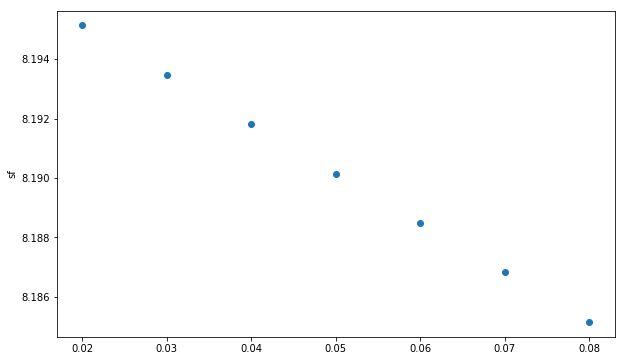

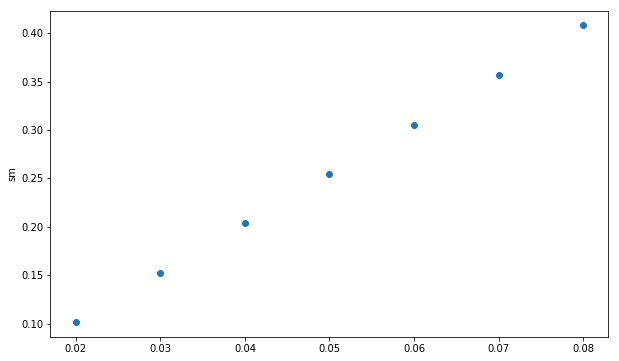

In [123]:
sol1=np.array(sols)
#print(sol1.T[0])
plt.figure(figsize=(10,6))
plt.plot(kleakrange,sol1.T[0],'o')
plt.ylabel("sf")
plt.figure(figsize=(10,6))
plt.plot(kleakrange,sol1.T[1],'o')
plt.ylabel("sm")
#plt.plot(kleakrange,sol1.T[0])

In [136]:
kleakrange[5], sols[5]

(0.07, array([8.1868252 , 0.35669354]))

In [144]:
#second constraint
def opt_leak_alpha(alpha,sf,sm,kleak):
    #constructing v0 initial vector
    Ca=100e-9
    cae=0#250.24e-6
    pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
    npmca = 180
    p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
    calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
    2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM
    v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]

    #v0[-7:-1] =[ 0.6420802891222142, 0.30574391044577887, 0.035928792193863426, 0.005142394529773396, 0.008226136319601385, 0.002878477474144645] 

    #Changing parameters
    k=k_orig.copy()
    #sf=3
    #sm=3.53087274

    #sm=1/np.polyval(fit1,sf)
    for key in ['kx1_x1a','kx1a_x2','ky2_y1a','ky1a_y1']:
        k[key]=sf*k[key]
    for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
        k[key]=sm*k[key]

    k['kleak']=kleak*alpha#0.014*0.2 #0.21405838101231592#0.09519188799639043
    #print(k)

    tstep = 1e-2
    tf = 10000
    t = np.linspace(0, tf, tf/tstep+1)
    M=new_model(k)
    # Solve ODE
    sol = odeint(M.ode,v0,t)
    #print(sol[-1,-1],"sf,sm=",sf,sm)
    return sol[-1,-1]-500e-6

In [145]:
fsolve(opt_leak_alpha,0.2,args=(8.1868252, 0.35669354, 0.07))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


array([0.39623658])

In [143]:
#print parameters to copy into mdls
k=k_orig.copy()
sf=8.1868252
sm=0.35669354
for key in ['kx1_x1a','kx1a_x2','ky2_y1a','ky1a_y1']:
    k[key]=sf*k[key]
for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
    k[key]=sm*k[key]

for key in k.keys():
    print('k_SERCA_'+key.replace('k','').upper()+' = '+str(k[key]))

k_SERCA_X1_X1A = 1637365040.0
k_SERCA_X1A_X2 = 818682520.0
k_SERCA_X1A_X1 = 83.666
k_SERCA_X2_X1A = 167.332
k_SERCA_X2_Y2 = 0.21401612399999997
k_SERCA_Y2_X2 = 1.46886399772
k_SERCA_Y2_Y1A = 491.455116756
k_SERCA_Y1A_Y1 = 245.727558378
k_SERCA_Y1A_Y2 = 100000.0
k_SERCA_Y1_Y1A = 200000.0
k_SERCA_Y1_X1 = 0.142677416
k_SERCA_X1_Y1 = 0.00042803224799999994
k_SERCA_LEA = 0
k_SERCA_CBHON = 5500000.0
k_SERCA_CBHOFF = 2.6
k_SERCA_CBMON = 43500000.0
k_SERCA_CBMOFF = 35.8
k_SERCA_PMCA01 = 150000000.0
k_SERCA_PMCA10 = 20
k_SERCA_PMCA12 = 100
k_SERCA_PMCA20 = 100000.0
k_SERCA_PMCA0LEA = 12.5


[0.14608167 0.43854768 0.32914486 0.04744164 0.03304028 0.00574388] 
Ca ER = 861.2536851452427 uM


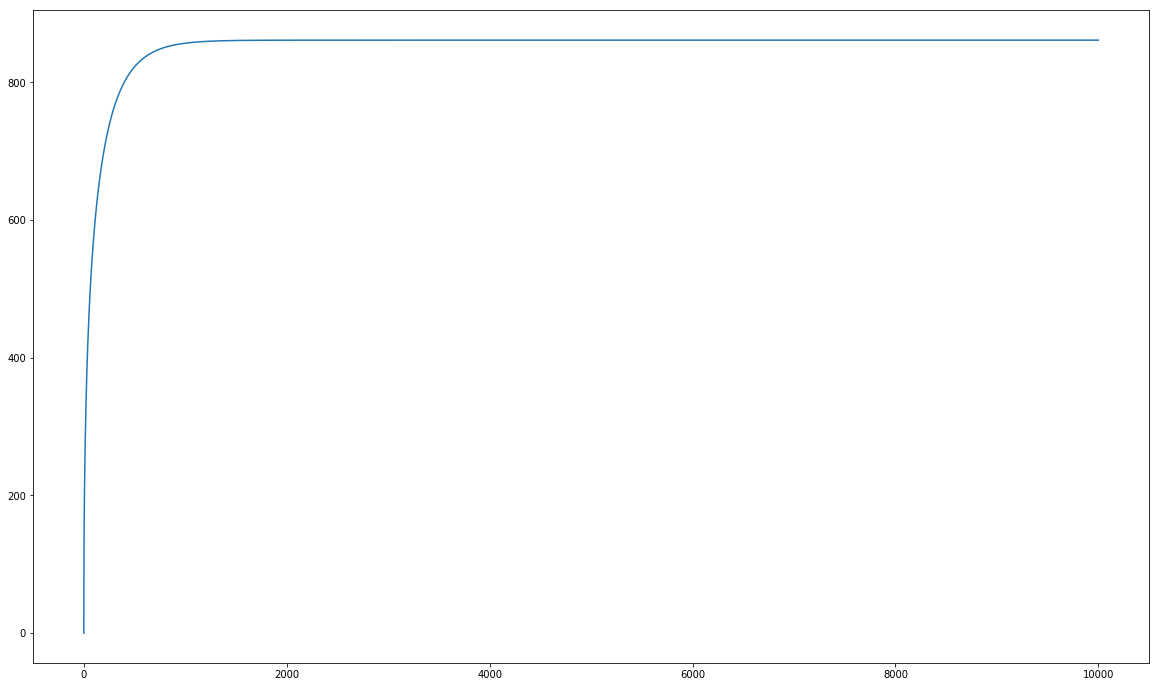

In [201]:
plt.figure(figsize=(20,12))
plt.plot(t,sol[:,-1]*1e6)
print(sol[-1,-7:-1],"\nCa ER =",sol[-1,-1]*1e6,"uM")

In [24]:
"aB2a".upper()

'AB2A'

# This is to see clamp behavior

In [10]:
#constructing v0 initial vector
Ca=100e-9
cae=250e-6#250.24e-6
pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
npmca = 180
p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM
v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]

#v0[-7:-1] =[ 0.6420802891222142, 0.30574391044577887, 0.035928792193863426, 0.005142394529773396, 0.008226136319601385, 0.002878477474144645] 

#Changing parameters 
k=k_orig.copy()
sf=2
sm=3.593
for key in ['kx1_x1a','kx1a_x2']:
    k[key]=sf*k[key]
for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
    k[key]=sm*k[key]

k['kleak']=0


tstep = 1e-4
tf = 100
t = np.linspace(0, tf, tf/tstep+1)
M=new_model(k)
M.er_clamp=1
# Solve ODE
sol = odeint(M.ode,v0,t)

NameError: name 'get_SERCA_equilibrium' is not defined

In [11]:
plt.figure(figsize=(20,12))
plt.plot(np.linspace(0,tf,len(M.flux)),np.array(M.flux)*1e6)#sol[:,-1]*1e6)
#plt.ylim((0,300))
print(list(sol[-1,:]))

NameError: name 'tf' is not defined

In [46]:
kleak=577#35.05#
ER_conc_rate=(2.1675*kleak+6.214988)*1e15/N_avo/vol_er*1e6

ER_conc_rate/250

0.21405838101231592

In [46]:
old=81775.83556434109
serca_conc_rate=500*1e15/N_avo/vol_er*1e6 #from MCell
print("N=",serca_conc_rate/old)

N= 0.00026033316269814734


In [72]:
5.3617692263536004e-05/(1e15/N_avo/vol_er)

1259.2838604210299

In [7]:
#from S Bandara et al 2013
J=0.014*250 #uM/s
J/=1e15/N_avo/vol_er*1e6
print("Ca Flux in ions/sec = ",J)

p=[2.1675959461586873, 6.214988757731395]
kleak=(J-p[1])/p[0]
print("Predicted MCell kleak = ",kleak)

Ca Flux in ions/sec =  82.20222328500002
Predicted MCell kleak =  35.05599586580223
